# Restoring the missing part of an image of simple coloured 3D objects
## Library imports

In [33]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import random

print('TensorFlow version:', tf.__version__)
print('NumPy version: ', np.__version__)

TensorFlow version: 2.3.0
NumPy version:  1.18.5


## 1. Acquire a dataset for training
### 1. Download the dataset

In [34]:
shape3d_bldr = tfds.builder('shapes3d')
shape3d_bldr.download_and_prepare()
shapes = shape3d_bldr.as_dataset(shuffle_files=False)
shapes = shapes['train']

### 2. Split the dataset into subsets

In [35]:
DATASET_SIZE = 480000

train_size = int(0.8 * DATASET_SIZE)
val_size = int(0.1 * DATASET_SIZE)
test_size = int(0.1 * DATASET_SIZE)

shapes_train = shapes.take(train_size)
shapes_test = shapes.skip(train_size)
shapes_valid = shapes_test.skip(test_size)
shapes_test = shapes_test.take(test_size)


## 2. Define the dataset image preprocessing function
### 1. Define all the necessary supporting functions
We will need a function to remove (substitute with black pixels) a part of the image, essentially adding artificial damage to it, which should will what the model is supposed to restore

In [36]:
def get_in_bounds(coord):
  if coord > 63:
    coord = 63
  elif coord < 0:
    coord = 0
  return coord

def remove_part(image):
  center_x = random.randint(0, 63)
  center_y = random.randint(0, 63)
  offset = random.randint(6, 10)
  coord_left = get_in_bounds(center_x - offset)
  coord_right = get_in_bounds(center_x + offset)
  coord_top = get_in_bounds(center_y - offset)
  coord_bottom = get_in_bounds(center_y + offset)

  image = image.numpy()
  image[coord_top:coord_bottom + 1, coord_left:coord_right + 1, :] = 0
  image = tf.convert_to_tensor(image, dtype=tf.uint8)
  return image

# Eager execution is disabled during dataset mapping, so we need to wrap remove_part()
# in tf.py_function() in order to access the image Tensor numpy array
def remove_part_map_fn(image):
  return tf.py_function(remove_part, inp=[image], Tout=tf.uint8)

### 2. Define the preprocessing function

In [37]:
def preprocess(example):
  image = example['image']
  image_removed = remove_part_map_fn(image)
  image_removed.set_shape([64, 64, 3])
  return (image / 255, image_removed / 255)

### 3. Check if the preprocessing function works as expected

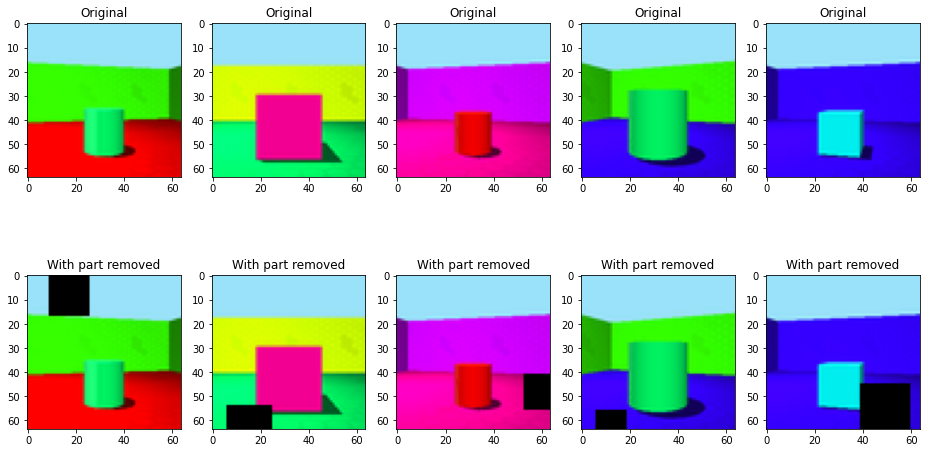

In [38]:
random.seed(1)

## Take and preprocess 5 examples:
examples = []
for example in shapes_train.take(5):
    examples.append(preprocess(example))

fig = plt.figure(figsize=(16, 8.5))

for column, (original, processed) in enumerate(examples):
    ax = fig.add_subplot(2, 5, 1 + column)
    ax.set_title('Original', size=12)
    ax.imshow(original)
    ax = fig.add_subplot(2, 5, 6 + column)
    ax.set_title('With part removed', size=12)
    ax.imshow(processed)

## 3. Preprocess the dataset

In [39]:
tf.random.set_seed(1)

BATCH_SIZE = 64
BUFFER_SIZE = 48000

steps_per_epoch = np.ceil(train_size / BATCH_SIZE)
print(steps_per_epoch)

shapes_train = shapes_train.map(
    lambda x: preprocess(x))
shapes_train = shapes_train.shuffle(buffer_size=BUFFER_SIZE).repeat()
shapes_train = shapes_train.batch(BATCH_SIZE)

shapes_valid = shapes_valid.map(
    lambda x: preprocess(x))
shapes_valid = shapes_valid.batch(BATCH_SIZE)

6000.0


## 4. Define the model architecture
The network architecture this one is based on is described in the conference paper "Understading Image Restoration Convolutional Neural Networks with Network Inversion" (2017, DOI: 10.1109/ICMLA.2017.0-156), the only differences
being the number of residual blocks, the sizes of the kernels and the final
activation function (Sigmoid instead of BReLU)
### 1. Define a residual block
This residual block will be the main repeating "layer" component in the network
- The idea of a residual block is used in ResNet, which is mentioned as the network architecture base in the referenced conference paper

In [40]:
class ResidualBlock(tf.keras.Model):
  def __init__(self):
    super(ResidualBlock, self).__init__(name='')

    self.conv2a = tf.keras.layers.Conv2D(64, (2, 2), padding='same')
    self.bn2a = tf.keras.layers.BatchNormalization()

    self.conv2b = tf.keras.layers.Conv2D(64, (2, 2), padding='same')
    self.bn2b = tf.keras.layers.BatchNormalization()

  def call(self, input_tensor, training=False):
    x = self.conv2a(input_tensor)
    x = self.bn2a(x, training=training)
    x = tf.nn.relu(x)

    x = self.conv2b(x)
    x = self.bn2b(x, training=training)

    x += input_tensor
    return x

### 2. Add starting layers of the network
We need to apply Batch normalization and bring the number of channels from 3 to 64

In [41]:
model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(
        64, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(),
])

model.compute_output_shape(input_shape=(None, 64, 64, 3))

TensorShape([None, 64, 64, 64])

### 3. Add residual blocks

In [42]:
for _ in range(12):
  model.add(ResidualBlock())
model.compute_output_shape(input_shape=(None, 64, 64, 3))

TensorShape([None, 64, 64, 64])

### 4. Add last layers of the network
We need to reduce the number of channels and use the sigmoid activation function to make sure  that the values for each channel of each pixel are in the range (0, 1)

In [43]:
model.add(tf.keras.layers.Conv2D(
        3, (3, 3), padding='same', activation='sigmoid'))
model.compute_output_shape(input_shape=(None, 64, 64, 3))

TensorShape([None, 64, 64, 3])

## 5. Build the model

In [44]:
tf.random.set_seed(1)
model.build(input_shape=(None, 64, 64, 3))

In [45]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_26 (Batc (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
batch_normalization_27 (Batc (None, 64, 64, 64)        256       
_________________________________________________________________
residual_block_12 (ResidualB (None, 64, 64, 64)        33408     
_________________________________________________________________
residual_block_13 (ResidualB (None, 64, 64, 64)        33408     
_________________________________________________________________
residual_block_14 (ResidualB (None, 64, 64, 64)        33408     
_________________________________________________________________
residual_block_15 (ResidualB (None, 64, 64, 64)       

## 6. Train the model for several epochs
Due to the number of residual blocks and the overall visual similarity between the examples, I decided to only train the network for a small number of epochs (which should still be enought)

In [46]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

history = model.fit(shapes_train, validation_data=shapes_valid,
                    epochs=3, steps_per_epoch=steps_per_epoch)

Epoch 1/3
6000/6000 [==============================] - 3567s 594ms/step - loss: 0.0286 - accuracy: 0.9081 - val_loss: 0.0275 - val_accuracy: 0.8873
Epoch 2/3
6000/6000 [==============================] - 3580s 597ms/step - loss: 0.0276 - accuracy: 0.9144 - val_loss: 0.0276 - val_accuracy: 0.8894
Epoch 3/3
6000/6000 [==============================] - 3570s 595ms/step - loss: 0.0275 - accuracy: 0.9155 - val_loss: 0.0274 - val_accuracy: 0.9393


## 7. Check the training results
### 1. Evaluate the model on the testing dataset

In [47]:
ds_test = shapes_test.map(
    lambda x:preprocess(x)).batch(32)
results = model.evaluate(ds_test, verbose=0)
print('Test Acc: {:.2f}%'.format(results[1] * 100))

Test Acc: 93.94%


### 2. Visualize a group of testing examples
We can see that restoration is quite effective, we don't even need ground truth pictures for reference

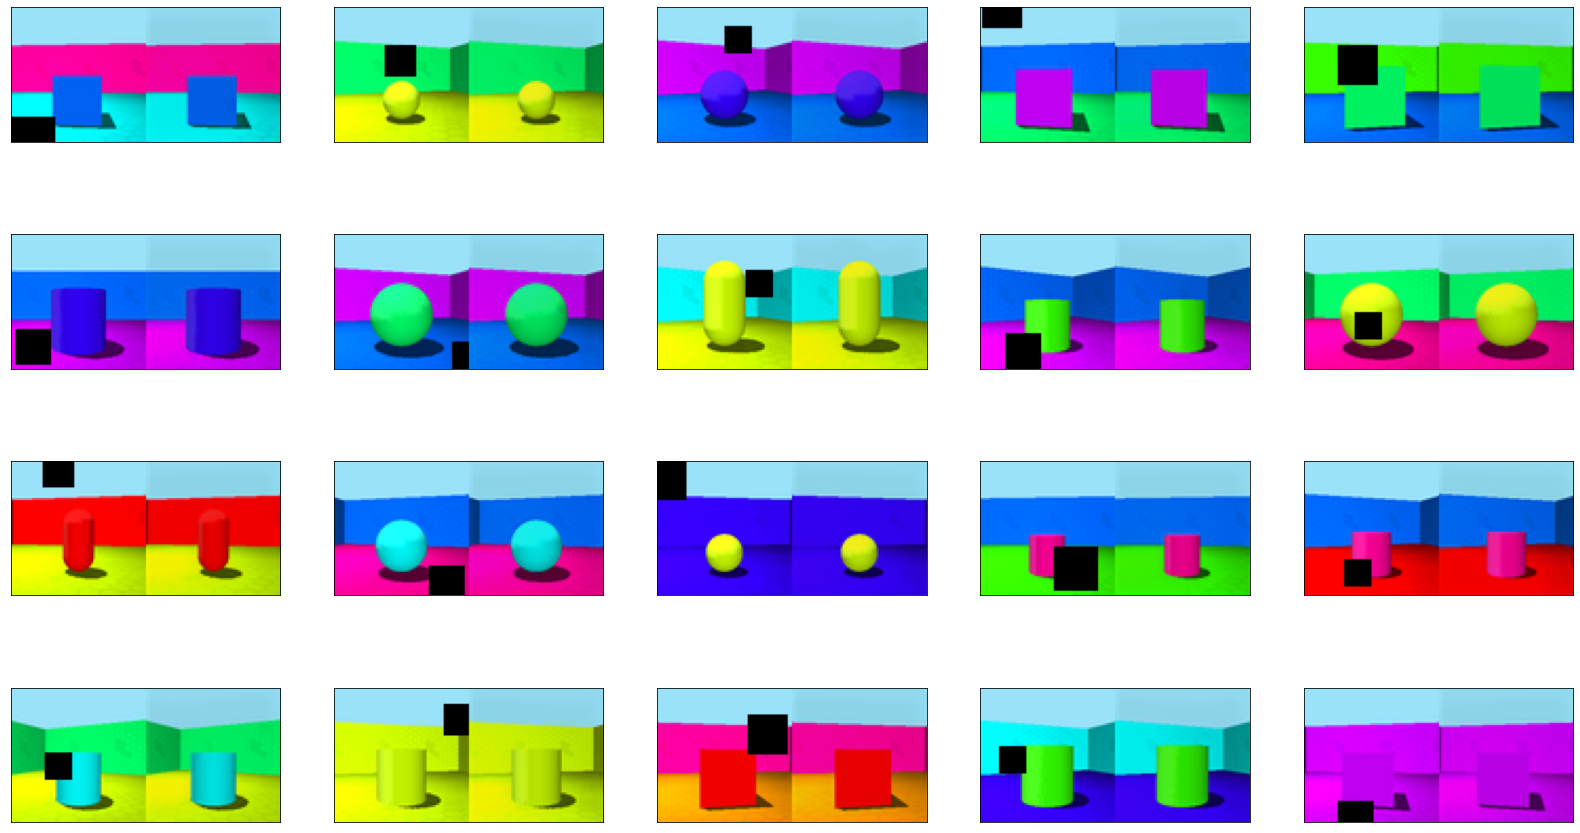

In [48]:
ds = ds_test.unbatch().take(20)

restored_imgs = model.predict(ds.batch(10))

fig = plt.figure(figsize=(28, 16))
for j, example in enumerate(ds):
    ax = fig.add_subplot(4, 5, j + 1)
    ax.set_xticks([]); ax.set_yticks([])
    comparison = np.concatenate((example[1], restored_imgs[j]), axis=1) 
    ax.imshow(comparison)
    
plt.show()

### 3. Plot the training history

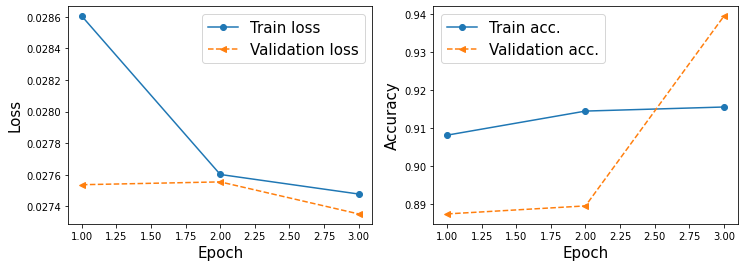

In [49]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

## 8. Conclusions, observations and afterthoughts
- The initial idea was to use an architecture similar to DeconvNet, which was the first network I managed to find during my initial research, which seemed to be applied to somewhat similar problems to the one I defined
- This proved to not be the case since DeconvNet has pooling and upsampling layers, usign which significantly reduces the end quality of the restored image, making it blurry due to the loss of important single pixel data for all pixels of the image
- I ended up considering a different architecture that is used specifically for image restoration, which is exactly what we want
- I ended up learning about residual blocks